In [1]:

# models - comparison:
# ResNet101V2,Xception,InceptionResNetV2,MobileNet,ResNet50V2,InceptionV3,MobileNetV2,VGG16,VGG19


In [2]:

# import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# execute if warnings should be ignored
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Create a list with the imagepaths for training and testing
#       from windows:  C:\Users\dietm\Documents\Data Science_Didi\Projekt\Projekt Recognition\data_vehicle_recognition\vehicles
dloadpath = Path('./data_vehicle_recognition/')
imagepaths = list(dloadpath.rglob('**/*.jpg'))


In [4]:
len(imagepaths)

522

In [5]:

imagepaths[138]


WindowsPath('data_vehicle_recognition/vehicles/bus/images (19).jpg')

In [6]:

# create a list with labels of the images:
labels = [str(imagepaths[i]).split("\\")[-2] for i in range(len(imagepaths))]


In [7]:
labels[138]

'bus'

In [8]:

# create a DataFrame with the filepath (as string) and the labels of the images

paths = pd.Series(imagepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate paths and labels
df = pd.concat([paths, labels], axis=1)

# shuffle the DataFrame and reset index and remove the old one:
df01 = df.sample(frac=1,random_state=42).reset_index(drop=True)


In [9]:

df01.head()


,Filepath,Label
0,data_vehicle_recognition\vehicles\scooty\image...,scooty
1,data_vehicle_recognition\vehicles\scooty\image...,scooty
2,data_vehicle_recognition\vehicles\bike\2Q__ (6...,bike
3,data_vehicle_recognition\vehicles\car\images (...,car
4,data_vehicle_recognition\vehicles\boat\images ...,boat


In [10]:

# 9 different labels and their titles:
df01.Label.unique()


array(['scooty', 'bike', 'car', 'boat', 'helicopter', 'truck', 'bus',
       'plane', 'cycle'], dtype=object)

In [11]:
type(df01["Filepath"])

pandas.core.series.Series

In [12]:

# total number of images:
df01.shape[0]


522

In [13]:

# total number of images each category:
df01.Label.value_counts()


Label
car           65
cycle         65
scooty        63
helicopter    57
bike          55
boat          55
truck         55
bus           55
plane         52
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

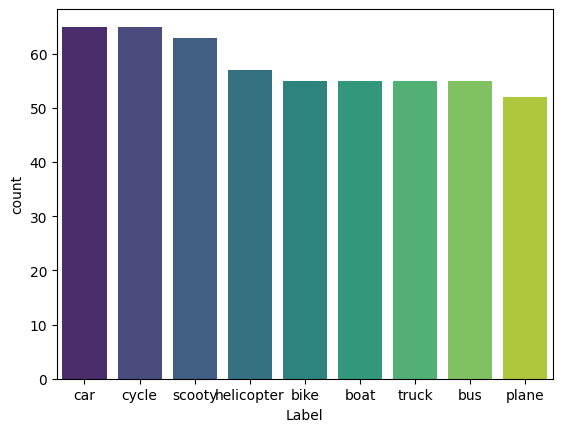

In [14]:

# number of images each category visualized: --> different numbers
sns.countplot(data=df01,x="Label",palette="viridis",order=df01.Label.value_counts().index)


In [15]:

# for a better train_data_set --> all categories with same size: 52
list_indizes = []

for i in df01.Label.unique():
    if len(df01[df01.Label==f'{i}']) > 52:
        [list_indizes.append(i) for i in df01[df01.Label==f'{i}'].iloc[:(len(df01[df01.Label==f'{i}']) - 52),:].index]        


In [24]:
len(list_indizes)

54

In [25]:

# delete the rows of the data set:
df01.drop(index=list_indizes,inplace=True)


In [26]:
df01.Label.value_counts()

Label
truck         52
bus           52
plane         52
bike          52
boat          52
helicopter    52
car           52
scooty        52
cycle         52
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

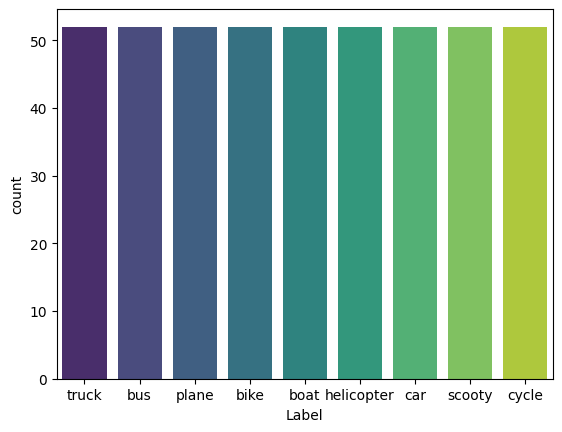

In [27]:
sns.countplot(data=df01,x="Label",palette="viridis",order=df01.Label.value_counts().index)

In [28]:

# create new indices for the data set and remove the old one:
df01.reset_index(drop=True,inplace=True)


In [29]:

# shape data set: 522 --> 468 rows with 2 features:
df01


,Filepath,Label
0,data_vehicle_recognition\vehicles\truck\2Q__.jpg,truck
1,data_vehicle_recognition\vehicles\bus\Z (12).jpg,bus
2,data_vehicle_recognition\vehicles\plane\9k_ (6...,plane
3,data_vehicle_recognition\vehicles\bus\images (...,bus
4,data_vehicle_recognition\vehicles\truck\images...,truck
...,...,...
463,data_vehicle_recognition\vehicles\boat\9k_ (5)...,boat
464,data_vehicle_recognition\vehicles\boat\Z (6).jpg,boat
465,data_vehicle_recognition\vehicles\cycle\images...,cycle
466,data_vehicle_recognition\vehicles\scooty\image...,scooty


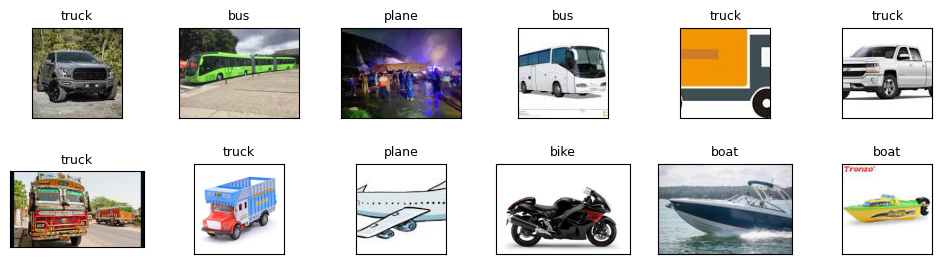

In [30]:

# visualization of images with subplots without scalenumbers:
fig, axes = plt.subplots(nrows=2,ncols=6,subplot_kw={'xticks':[],'yticks':[]},figsize=(10,3))

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df01.Filepath[i]))
    ax.set_title(df01.Label[i],fontsize=9)

plt.tight_layout(pad=2)
plt.show()


In [31]:

# import library for image recognition:
import tensorflow as tf


In [32]:

from sklearn.model_selection import train_test_split


In [33]:

# train/test split
# use only a small part of the data set in the case of being very big
# --> "df01.sample(frac=0.1)"
train_df,test_df = train_test_split(df01, test_size=0.2,random_state=42)


In [34]:

# load the images with a generator and data augmentation with a function:
def image_gen():
    
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

    train_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath',y_col='Label',
                                                       target_size=(224, 224),class_mode='categorical',
                                                       batch_size=32,seed=0,subset='training',rotation_range=30,
                                                       zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                                                       shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

    val_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath',y_col='Label',
                                                     target_size=(224, 224),class_mode='categorical',batch_size=32,
                                                     seed=0,subset='validation',rotation_range=30,zoom_range=0.15,
                                                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,
                                                     horizontal_flip=True,fill_mode="nearest")

    test_images = test_generator.flow_from_dataframe(dataframe=test_df,x_col='Filepath',y_col='Label',
                                                     target_size=(224, 224),class_mode='categorical',batch_size=32,
                                                     shuffle=False)
    
    return train_generator,test_generator,train_images,val_images,test_images
    

In [35]:

# loading the pretrained model with an initialized keras_model:
def model_choice(model):
    
    kwargs = {'input_shape':(224, 224, 3),'include_top':False,'weights':'imagenet','pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # number of labels --> 9:
    outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model


In [36]:

# dictionary with the keras_models:
# --> a collection of models with good values in accuracy and training times:
models = {
    "ResNet101V2": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0}
}


In [37]:

# import library for counting the training time:
from time import perf_counter


In [38]:

# create the generators:
train_generator,test_generator,train_images,val_images,test_images = image_gen()

# fit with all models:
for name, model in models.items():
    
    # Get the model
    m = model_choice(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=3,verbose=0)
    
    # Save the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]


Found 300 validated image filenames belonging to 9 classes.
Found 74 validated image filenames belonging to 9 classes.
Found 94 validated image filenames belonging to 9 classes.
ResNet101V2          trained in 102.18 sec
Xception             trained in 111.27 sec

InceptionResNetV2    trained in 156.81 sec
MobileNet            trained in 27.41 sec
ResNet50V2           trained in 90.05 sec
InceptionV3          trained in 65.98 sec
MobileNetV2          trained in 31.25 sec
VGG16                trained in 249.48 sec
VGG19                trained in 326.92 sec


In [39]:

# import libraries for evaluation:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [40]:

# evaluation of all models
for name, model in models.items():
    
    # predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step  WARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002756B1BD240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
3/3 ━━━━━━━━━

In [41]:

# create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results


,model,val_accuracy,accuracy,Training time (sec)
0,InceptionResNetV2,0.9189,0.9681,156.81
1,InceptionV3,0.9459,0.9681,65.98
2,Xception,0.9324,0.9149,111.27
3,ResNet101V2,0.8514,0.8830,102.18
4,MobileNet,0.9189,0.8617,27.41
5,ResNet50V2,0.8919,0.8617,90.05
6,MobileNetV2,0.8919,0.8617,31.25
7,VGG16,0.6486,0.5851,249.48
8,VGG19,0.5811,0.5000,326.92


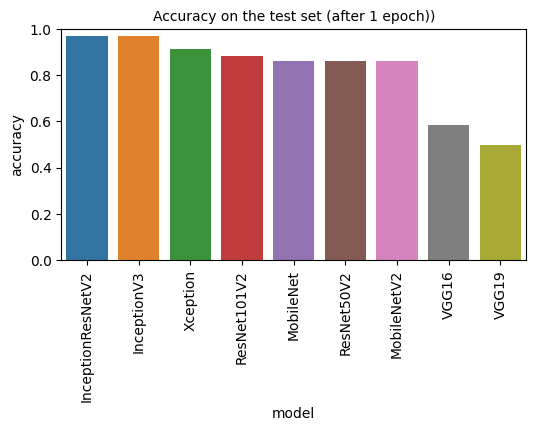

In [42]:

plt.figure(figsize = (6,3))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 10)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()


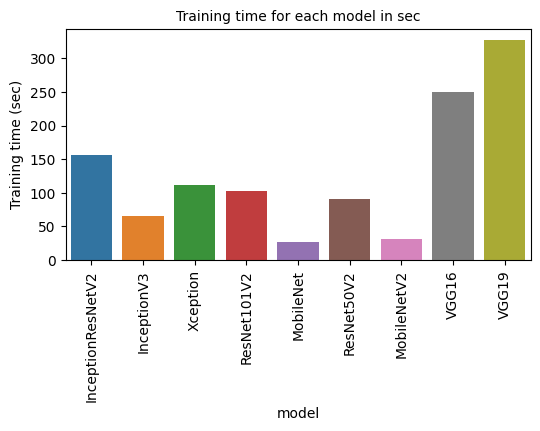

In [43]:

plt.figure(figsize = (6,3))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 10)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()
